In [1]:
"""
Generate reports for comparison.
"""
import os
import os.path as op
from os import remove
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nibabel as nib
from nipype.algorithms import confounds as nac
from nilearn import plotting, image
from nilearn.masking import compute_epi_mask, apply_mask
from niworkflows.viz import plots

/Users/tsalo/Documents/tsalo/niworkflows/niworkflows/__init__.py:39: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/tsalo/anaconda/envs/python3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/tsalo/anaconda/envs/python3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-pa

In [2]:
color_dict = {'accepted': 'green',
              'midk': 'yellow',
              'rejected': 'red',
              'ignored': 'gray'}


def plot_spectra(ct_df):
    fig, ax = plt.subplots(figsize=(10, 10))

    for clf in ct_df['classification'].unique():
        red_df = ct_df.loc[ct_df['classification'] == clf]
        if red_df.shape[0] > 0:
            kappas = red_df['kappa']
            rhos = red_df['rho']
            varex = red_df['normalized variance explained']
            ax.scatter(x=kappas, y=rhos, color=color_dict.get(clf, 'gray'), alpha=0.5,
                       edgecolors='black', label=clf, s=(varex*50)+25)

    ax.set_xlabel('Kappa')
    ax.set_ylabel('Rho')
    legend = ax.legend(frameon=True)
    for legend_handle in legend.legendHandles:
        legend_handle.set_sizes([50])
    
    return fig, ax


def plot_image(img, vmin=None, vmax=None):
    if isinstance(img, str):
        img = nib.load(img)
    
    dat = img.get_data()
    if vmin:
        dat[dat < vmin] = np.max((vmin, 0))
        vmin = np.min(dat)
    if not vmax:
        vmax = np.max(dat)
    
    coords = np.arange(-10, 62, 2, int)
    n_cols = 8
    n_rows = int(len(coords) / n_cols)
    start = 0
    end = n_cols

    fig, axes = plt.subplots(nrows=n_rows, figsize=(2*n_cols, 4*n_rows))
    for row in range(n_rows):
        row_coords = coords[start:end]
        plotting.plot_stat_map(
            stat_map_img=img, bg_img=None, display_mode='z',
            cut_coords=row_coords, axes=axes[row],
            annotate=False, vmax=vmax)
        start += n_cols
        end += n_cols
    return fig, axes


def plot_anatomical(img):
    if isinstance(img, str):
        img = nib.load(img)
    
    coords = np.arange(-10, 62, 2, int)
    n_cols = 8
    n_rows = int(len(coords) / n_cols)
    start = 0
    end = n_cols

    fig, axes = plt.subplots(nrows=n_rows, figsize=(2*n_cols, 4*n_rows))
    for row in range(n_rows):
        row_coords = coords[start:end]
        plotting.plot_anat(
            img, display_mode='z',
            cut_coords=row_coords, axes=axes[row],
            annotate=False)
        start += n_cols
        end += n_cols
    return fig, axes

In [21]:
tedana_dir = '/Users/tsalo/Documents/tsalo/tedana-comparison/sandbox/current-dectree/'
#tedana_dir = '/Users/tsalo/data/TED/'
files = sorted(glob('/Users/tsalo/Documents/tsalo/tedana-comparison/sandbox/e5_data/*.nii.gz'))
mask = compute_epi_mask(files[4])
m = mask.get_data()
mask_file = 'temp_mask.nii.gz'
mask.to_filename(mask_file)

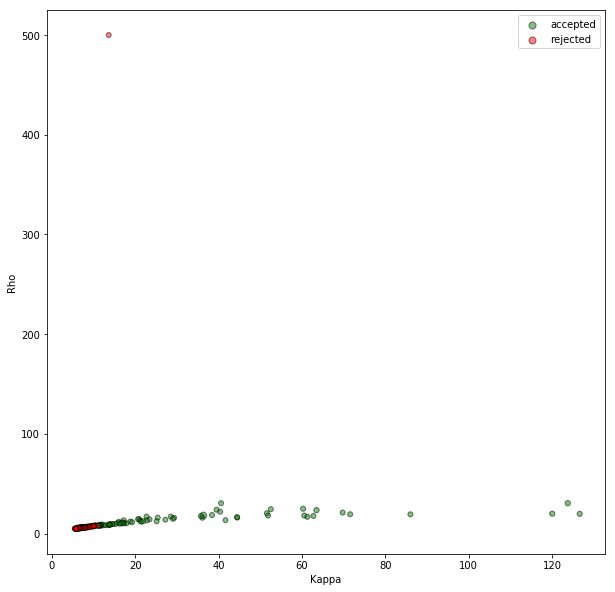

In [4]:
comptable_file = op.join(tedana_dir, 'comp_table_pca.txt')
comptable = pd.read_csv(comptable_file, sep='\t')

fig, ax = plot_spectra(comptable)

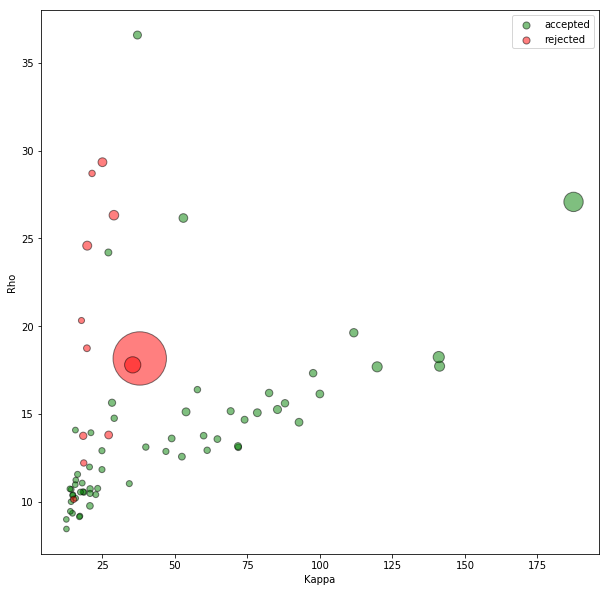

In [5]:
comptable_file = op.join(tedana_dir, 'comp_table_ica.txt')
comptable = pd.read_csv(comptable_file, sep='\t')

fig, ax = plot_spectra(comptable)

In [6]:
#raise Exception()

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


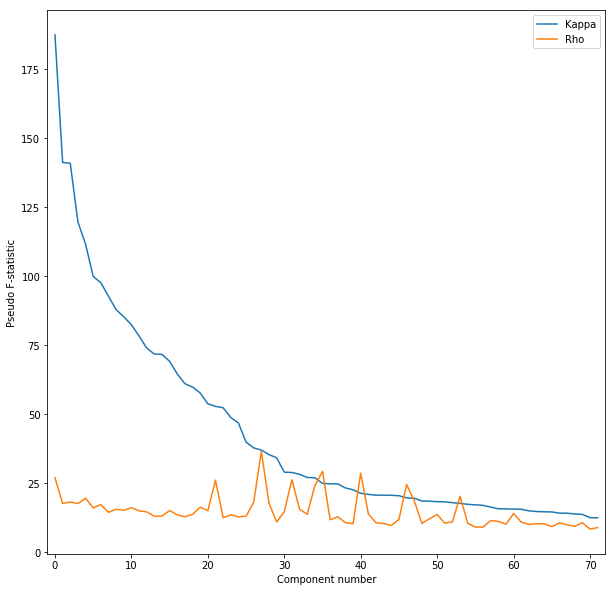

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(comptable['kappa'], label='Kappa')
ax.plot(comptable['rho'], label='Rho')
ax.set_ylabel('Pseudo F-statistic')
ax.set_xlabel('Component number')
ax.set_xlim(-1, comptable.shape[0])
legend = ax.legend(frameon=True)
fig.show()

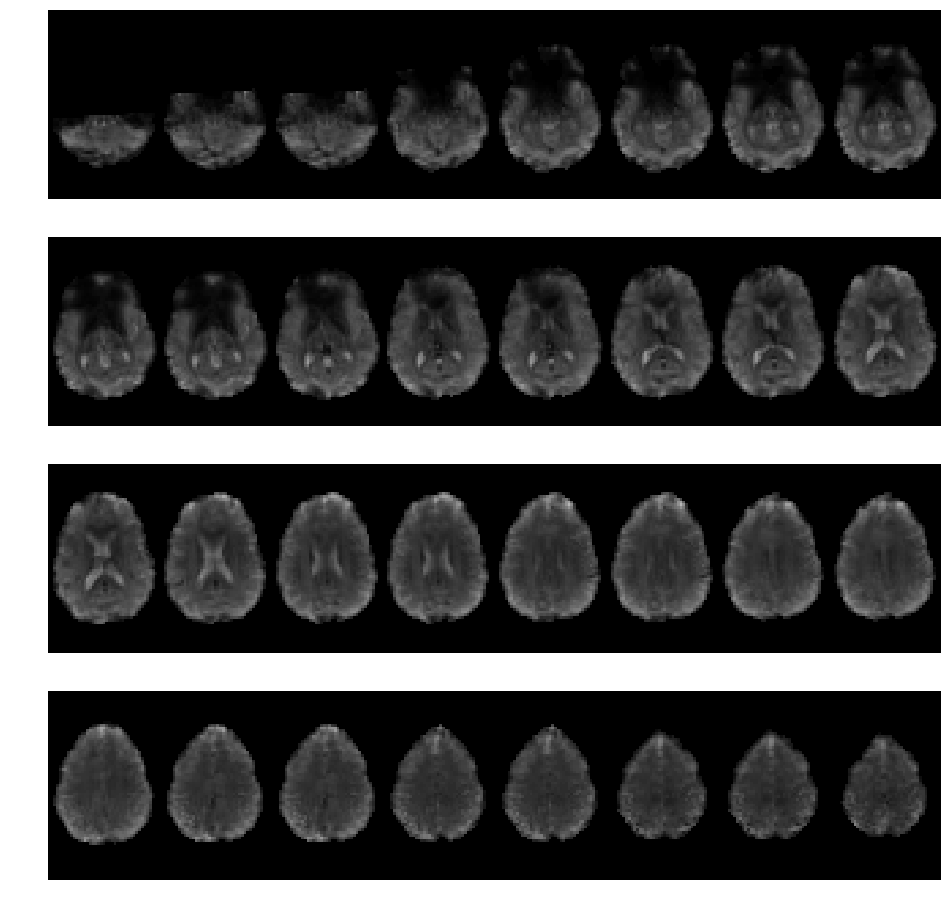

In [8]:
imgs = [nib.load(f) for f in files]
data = np.stack([img.get_data() for img in imgs], axis=-1)
data = np.mean(np.mean(data, axis=-1), axis=-1)

img = image.mean_img(files[4])
img2 = nib.Nifti1Image(data, imgs[0].affine)

fig, ax = plot_anatomical(img)

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


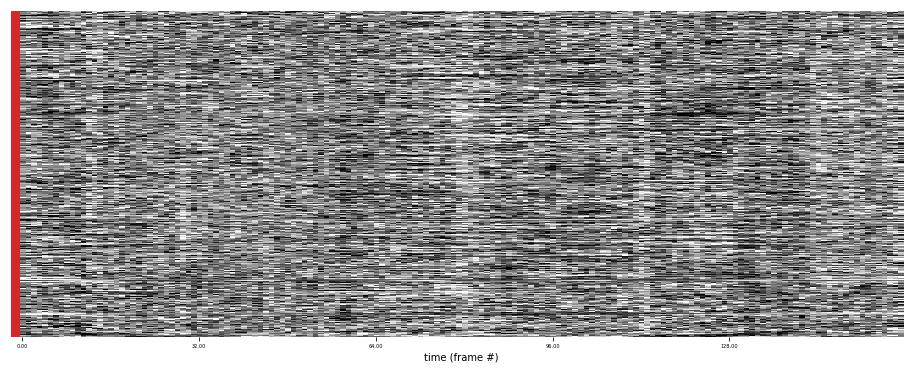

In [9]:
fig, ax = plt.subplots(figsize=(16, 6))
plots.plot_carpet(files[4], m, subplot=ax)
fig.show()

In [38]:
for f in files:
    tsnr = nac.TSNR()
    tsnr.inputs.in_file = f
    res = tsnr.run()
    
    dvars = nac.ComputeDVARS()
    dvars.inputs.in_file = f
    dvars.inputs.in_mask = mask_file
    res2 = dvars.run()
    print(res2.outputs.avg_nstd)

    tsnr_arr = apply_mask(res.outputs.tsnr_file, mask)
    mean_tsnr = np.mean(tsnr_arr)
    print(mean_tsnr)
    #fig, ax = plot_image(res.outputs.tsnr_file)
    #fig.suptitle(f)
    #fig.show()


/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/nitime-0.7-py3.6-macosx-10.7-x86_64.egg/nitime/utils.py:980: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, np.complex) or
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/nitime-0.7-py3.6-macosx-10.7-x86_64.egg/nitime/utils.py:981: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, np.complex))
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/fftpack/basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as a

2.543395519256592
409.3029


/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/nitime-0.7-py3.6-macosx-10.7-x86_64.egg/nitime/utils.py:980: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, np.complex) or
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/nitime-0.7-py3.6-macosx-10.7-x86_64.egg/nitime/utils.py:981: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, np.complex))
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/fftpack/basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as a

3.456879138946533
286.2137


/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/nitime-0.7-py3.6-macosx-10.7-x86_64.egg/nitime/utils.py:980: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, np.complex) or
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/nitime-0.7-py3.6-macosx-10.7-x86_64.egg/nitime/utils.py:981: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, np.complex))
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/fftpack/basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as a

4.428804874420166
215.72858


/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/nitime-0.7-py3.6-macosx-10.7-x86_64.egg/nitime/utils.py:980: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, np.complex) or
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/nitime-0.7-py3.6-macosx-10.7-x86_64.egg/nitime/utils.py:981: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, np.complex))
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/fftpack/basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as a

5.734431743621826
162.57826


/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/nitime-0.7-py3.6-macosx-10.7-x86_64.egg/nitime/utils.py:980: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, np.complex) or
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/nitime-0.7-py3.6-macosx-10.7-x86_64.egg/nitime/utils.py:981: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, np.complex))
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/fftpack/basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as a

7.466696262359619
122.96816


1.0135929584503174

321.6730693595893


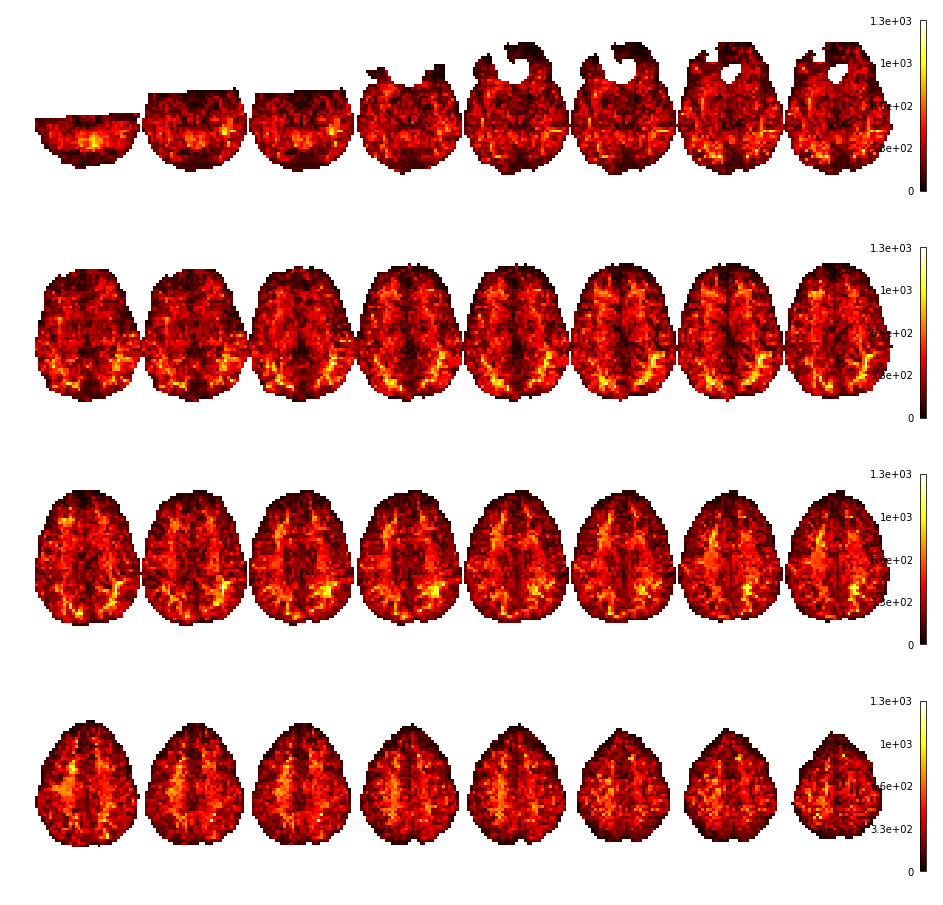

In [11]:
f = op.join(tedana_dir, 'ts_OC.nii')

tsnr = nac.TSNR()
tsnr.inputs.in_file = f
res = tsnr.run()

tsnr_arr = apply_mask(res.outputs.tsnr_file, mask)
mean_tsnr = np.mean(tsnr_arr)
print(mean_tsnr)

fig, ax = plot_image(res.outputs.tsnr_file)

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


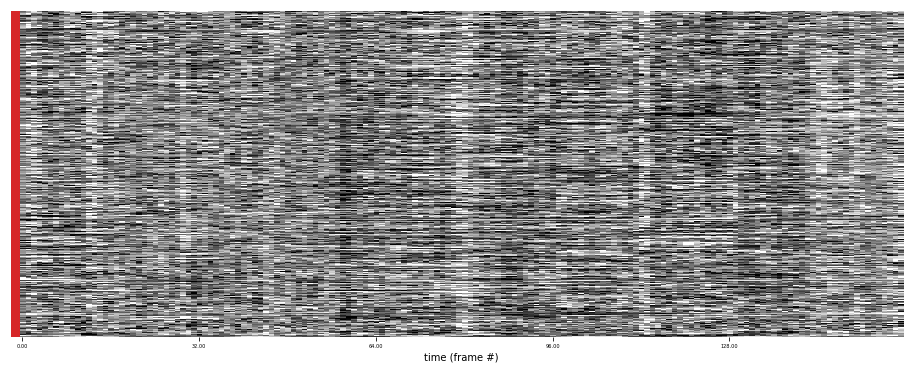

In [12]:
fig, ax = plt.subplots(figsize=(16, 6))
plots.plot_carpet(f, m, subplot=ax)
fig.show()

479.4378768201901


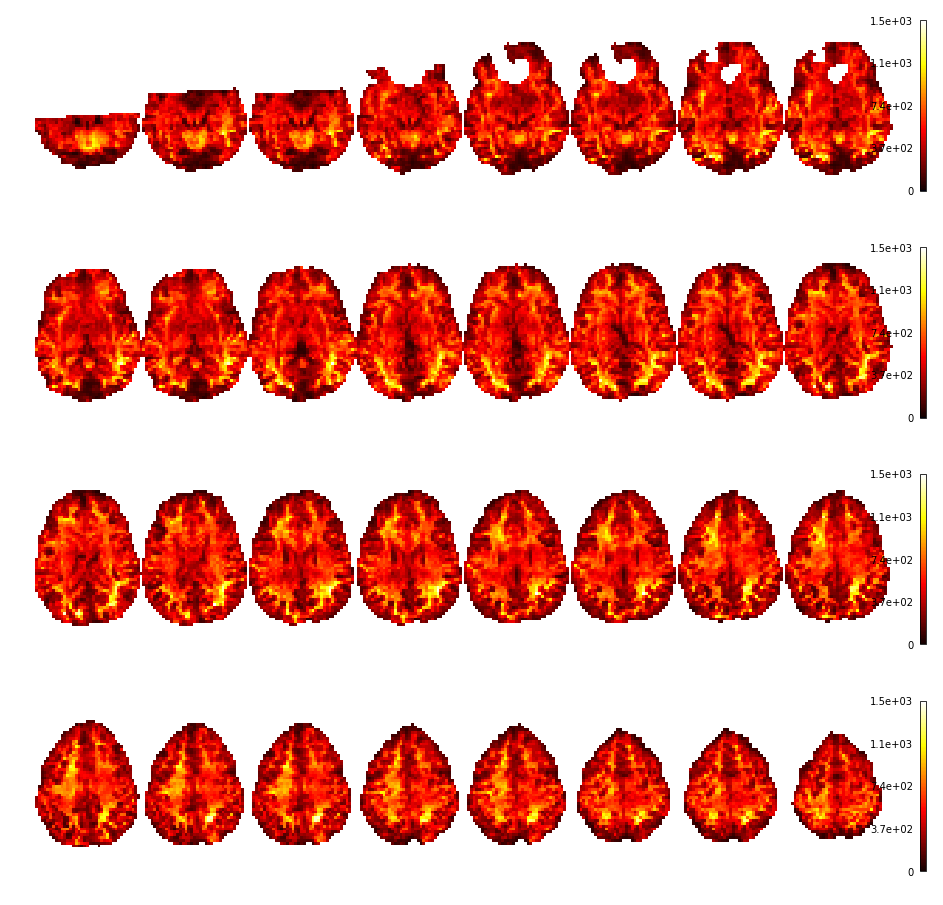

In [13]:
f = op.join(tedana_dir, 'dn_ts_OC.nii')

tsnr = nac.TSNR()
tsnr.inputs.in_file = f
res = tsnr.run()

tsnr_arr = apply_mask(res.outputs.tsnr_file, mask)
mean_tsnr = np.mean(tsnr_arr)
print(mean_tsnr)

fig, ax = plot_image(res.outputs.tsnr_file)

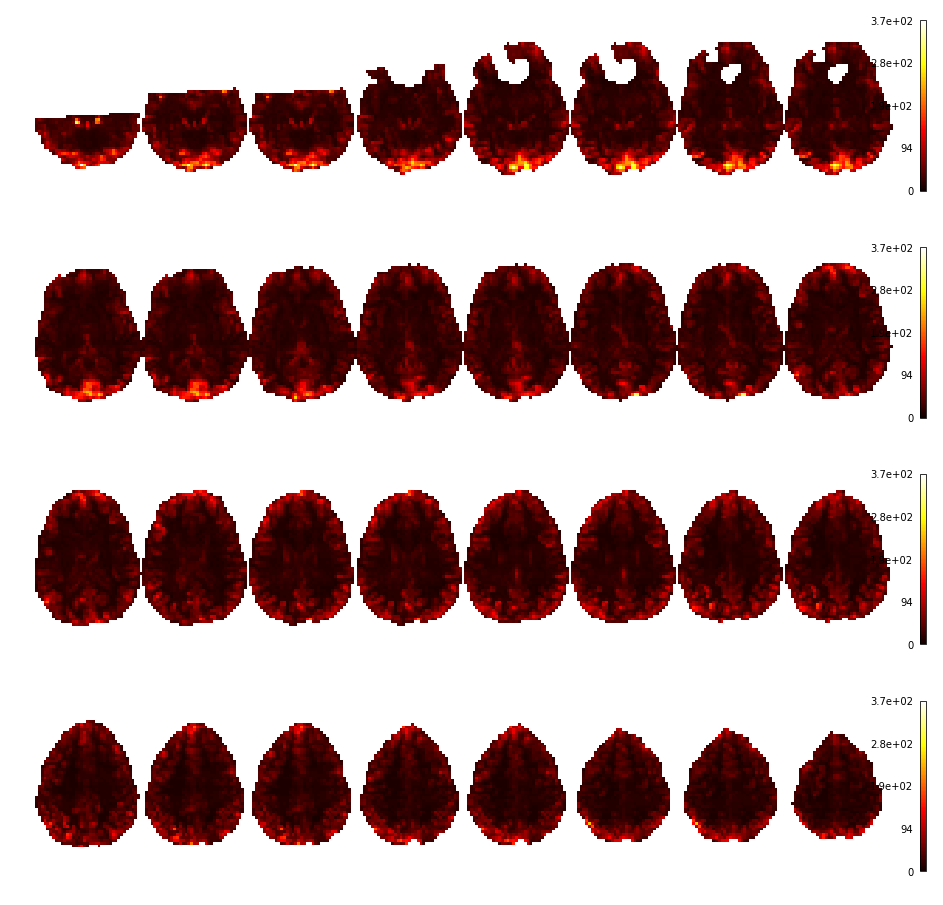

In [14]:
img = nib.load(f)
data = img.get_data()
data = np.std(data, axis=-1)
img2 = nib.Nifti1Image(data, img.affine)

fig, ax = plot_image(img2)

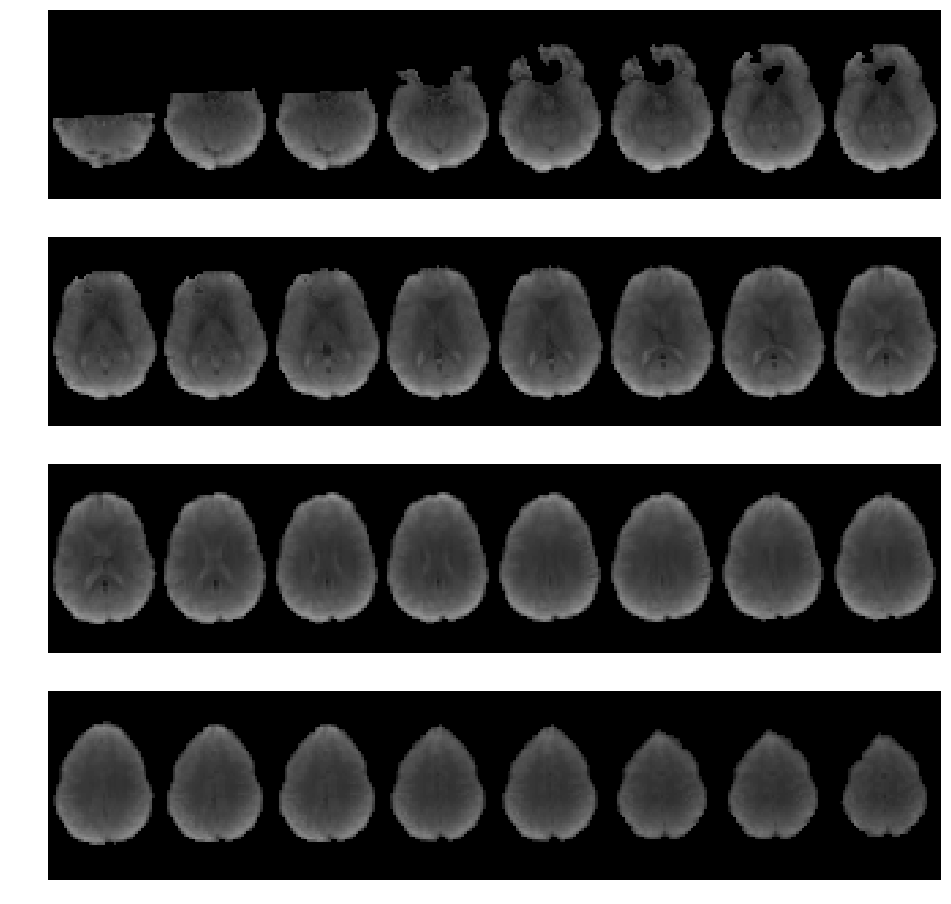

In [15]:
img = nib.load(f)
data = img.get_data()
data = np.mean(data, axis=-1)
img2 = nib.Nifti1Image(data, img.affine)

fig, ax = plot_anatomical(img2)

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


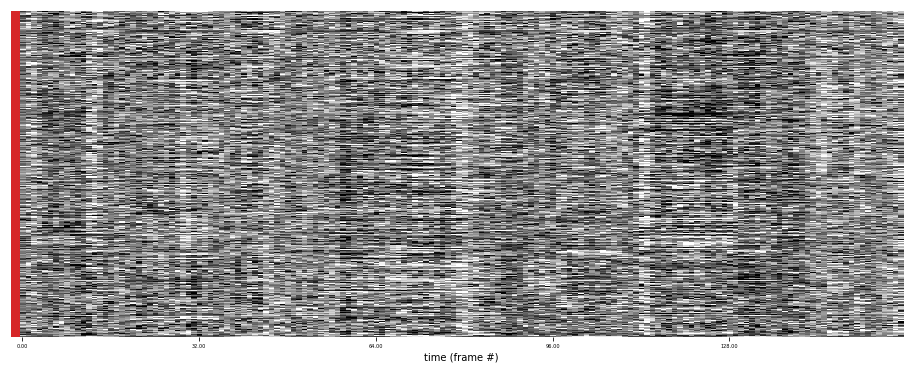

In [16]:
fig, ax = plt.subplots(figsize=(16, 6))
plots.plot_carpet(f, m, subplot=ax)
fig.show()

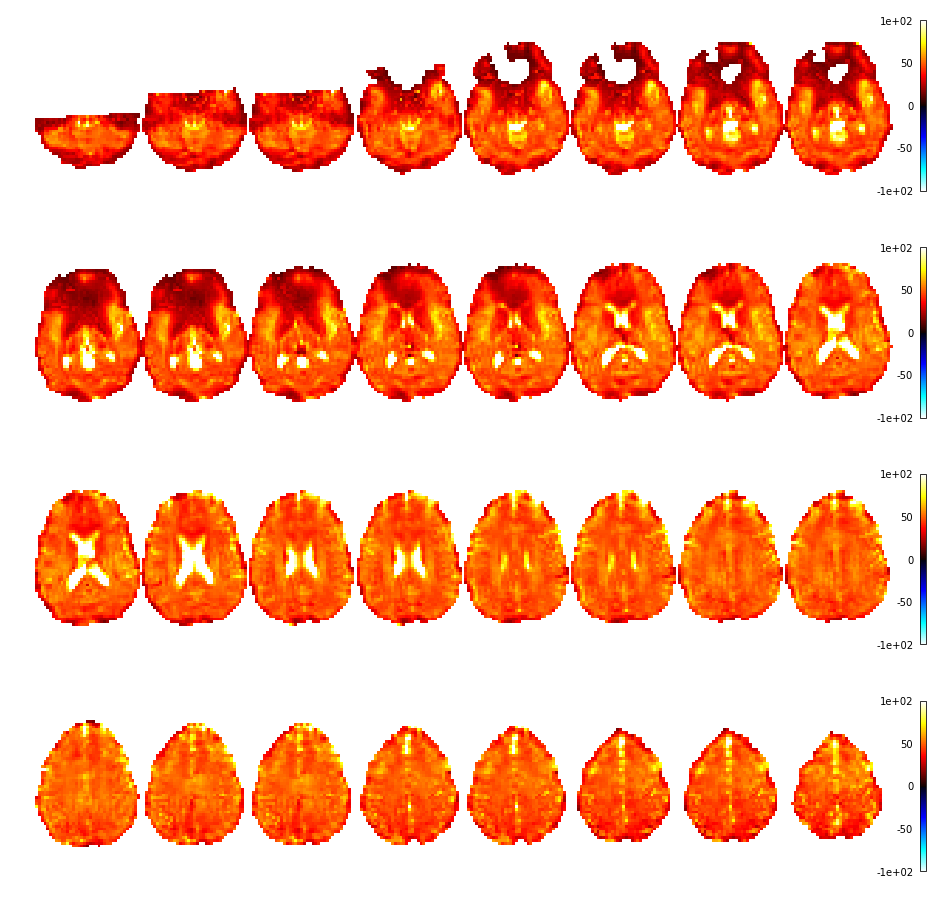

In [17]:
fig, ax = plot_image(op.join(tedana_dir, 't2sv.nii'), vmin=0, vmax=100)

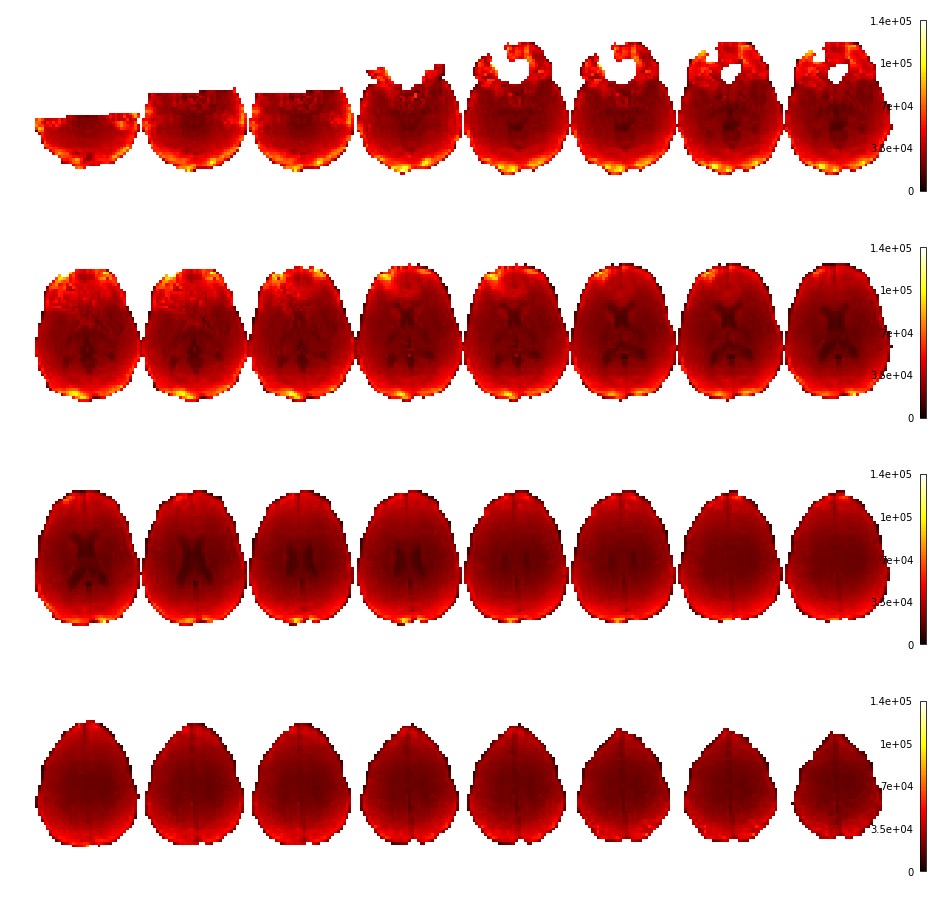

In [18]:
fig, ax = plot_image(op.join(tedana_dir, 's0v.nii'))

In [19]:
remove(res.outputs.mean_file)
remove(res.outputs.stddev_file)
remove(res.outputs.tsnr_file)
remove(mask_file)
remove(res2.outputs.out_std)